In [2]:
import pandas as pd
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import torch 

import pickle
from kg import KnowledgeGraph


In [3]:
device = 'cpu'

data_dir = os.environ.get('DATA_DIR', './Data')
output_dir = os.environ.get('OUTPUT_DIR', './Output')

In [4]:
## Add node indices
## nodes_df: Dataframe containing node information with columns: node_idx, node_id, node_type
## relations_df: Dataframe containing relation information with columns: source ID/type, target ID/type

def add_node_indices(nodes_df, relations_df):
    """
    Add node indices from nodes dataframe to relations dataframe based on ID and type matching.
    
    Args:
    	nodes_df (pd.DataFrame): Dataframe containing node information with columns: node_idx, node_id, node_type
    	relations_df (pd.DataFrame): Dataframe containing relation information with columns: x_id, x_type, y_id, y_type
   
    Returns:
    	pd.DataFrame: Filtered relations dataframe with added x_idx, y_idx, and included columns
    """
    # Create a copy of the relations dataframe to avoid modifying the original
    result_df = relations_df.copy()
    
    # Convert node_id to string type in nodes_df for consistent matching
    nodes_df = nodes_df.copy()
    nodes_df['node_id'] = nodes_df['node_id'].astype(str)
    
    # Convert x_id and y_id to string type in relations_df
    result_df['x_id'] = result_df['x_id'].astype(str)
    result_df['y_id'] = result_df['y_id'].astype(str)
    
    # Create a mapping dictionary from (node_id, node_type) to node_idx
    node_mapping = pd.Series(
        nodes_df.node_idx.values,
        index=pd.MultiIndex.from_arrays([nodes_df.node_id, nodes_df.node_type])
    ).to_dict()
    
    # Create a function to safely get mapping value
    def get_mapping(row, id_col, type_col):
        key = (row[id_col], row[type_col])
        return node_mapping.get(key)
    
    # Add x_idx column by mapping (x_id, x_type)
    result_df['x_idx'] = result_df.apply(
        lambda row: get_mapping(row, 'x_id', 'x_type'), 
        axis=1
    )
    
    # Add y_idx column by mapping (y_id, y_type)
    result_df['y_idx'] = result_df.apply(
        lambda row: get_mapping(row, 'y_id', 'y_type'), 
        axis=1
    )
    
    # Check if both indices are valid (not NaN) and add 'included' column
    result_df['included'] = result_df['x_idx'].notna() & result_df['y_idx'].notna()
    
    # Filter rows where both x_idx and y_idx are not NaN
    result_df = result_df[result_df['included']].copy()
    
    # Convert x_idx and y_idx to integers
    result_df['x_idx'] = result_df['x_idx'].astype(int)
    result_df['y_idx'] = result_df['y_idx'].astype(int)
    
    return result_df


data_dir = os.environ.get('DATA_DIR', './Data')
output_dir = os.environ.get('OUTPUT_DIR', './Output')

df = pd.read_csv(f'{data_dir}/knowledge_graph/8.9.21_kg/kg_giant_orphanet.csv')
print("Loading HPO to index dictionary...")

with open(f'{data_dir}/knowledge_graph/8.9.21_kg/hpo_to_idx_dict_8.9.21_kg.pkl', 'rb') as f:
    hpo_to_idx_dict = pickle.load(f)

print("Loading Genes to index dictionary...")
with open(f'{data_dir}/knowledge_graph/8.9.21_kg/ensembl_to_idx_dict_8.9.21_kg.pkl', 'rb') as file:
    genes = pickle.load(file)

with open(f'{data_dir}/preprocess/orphanet/orphanet_to_mondo_dict.pkl', 'rb') as file:
        orphanet_to_mondo_dict = pickle.load(file)

with open(f'{data_dir}/knowledge_graph/8.9.21_kg/mondo_to_idx_dict_8.9.21_kg.pkl', 'rb') as file:
    mondo_to_idx_dict = pickle.load(file)

# create_nodes_pkl(data_dir)
with open(f'{data_dir}/knowledge_graph/8.9.21_kg/nodes_8.9.21_kg.pkl', 'rb') as file:
    nodes = pickle.load(file)

/tmp/ipykernel_12839/2845939711.py:66: DtypeWarning: Columns (2,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'{data_dir}/knowledge_graph/8.9.21_kg/kg_giant_orphanet.csv')


Loading HPO to index dictionary...
Loading Genes to index dictionary...


In [5]:
# The nodes_8.9.21_kg.pkl file contains node information with columns: node_idx, node_id, node_type
with open(f'{data_dir}/knowledge_graph/8.9.21_kg/nodes_8.9.21_kg.pkl', 'rb') as file:
    nodes = pickle.load(file)

print("\nFirst 5 rows of the data:")
print(nodes.head(5),"\n")
print("there are:",nodes.shape[0],"of nodes \n")
print(nodes['node_type'].value_counts())


First 5 rows of the data:
   node_idx node_id     node_type        node_name node_source old_node_name
0         0    9796  gene/protein  ENSG00000168490        NCBI        PHYHIP
1         1    7918  gene/protein  ENSG00000204438        NCBI        GPANK1
2         2    8233  gene/protein  ENSG00000169249        NCBI         ZRSR2
3         3    4899  gene/protein  ENSG00000106459        NCBI          NRF1
4         4    5297  gene/protein  ENSG00000241973        NCBI         PI4KA 

there are: 105220 of nodes 

node_type
biological_process    28642
gene/protein          21610
disease               21233
effect/phenotype      15874
molecular_function    11169
cellular_component     4176
pathway                2516
Name: count, dtype: int64


In [6]:
# the kg_giant_orphanet.csv file contains the relationships between nodes with columns
# this is the predefined relationships between nodes
df = pd.read_csv(f'{data_dir}/knowledge_graph/8.9.21_kg/kg_giant_orphanet.csv')

print("\nFirst 5 rows of relationships:")
print(df.head(5), "\n")
print("there are:",df.shape[0],"of relationships \n")
print(df['relation'].value_counts())


/tmp/ipykernel_12839/3825346476.py:3: DtypeWarning: Columns (2,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'{data_dir}/knowledge_graph/8.9.21_kg/kg_giant_orphanet.csv')



First 5 rows of relationships:
          relation display_relation  x_id        x_type  x_name x_source  \
0  protein_protein              ppi  9796  gene/protein  PHYHIP     NCBI   
1  protein_protein              ppi  7918  gene/protein  GPANK1     NCBI   
2  protein_protein              ppi  8233  gene/protein   ZRSR2     NCBI   
3  protein_protein              ppi  4899  gene/protein    NRF1     NCBI   
4  protein_protein              ppi  5297  gene/protein   PI4KA     NCBI   

    y_id        y_type  y_name y_source  
0  56992  gene/protein   KIF15     NCBI  
1   9240  gene/protein   PNMA1     NCBI  
2  23548  gene/protein   TTC33     NCBI  
3  11253  gene/protein  MAN1B1     NCBI  
4   8601  gene/protein   RGS20     NCBI   

there are: 5471882 of relationships 

relation
drug_drug                     2672628
protein_present_anatomy       1518203
protein_protein                321075
disease_phenotype_positive     204779
protein_bioprocess             144805
disease_protein     

In [7]:
# View some HPO indices
print("Sample HPO indices:")
print(list(hpo_to_idx_dict.items())[:5])

# View some gene indices
print("\nSample gene indices:")
print(list(genes.items())[:5])

# View some disease indices
print("\nSample disease indices:")
print(list(mondo_to_idx_dict.items())[:5])

Sample HPO indices:
[('HP:0002240', 14012), ('HP:0001254', 14013), ('HP:0010547', 14014), ('HP:0001252', 14015), ('HP:0001250', 14016)]

Sample gene indices:
[('ENSG00000168490', 0), ('ENSG00000204438', 1), ('ENSG00000169249', 2), ('ENSG00000106459', 3), ('ENSG00000241973', 4)]

Sample disease indices:
[('13924', 19687), ('11160', 19688), ('8099', 19689), ('14854', 19690), ('33202', 19691)]


In [8]:
## enriched information about the nodes and their relationships
## output: result.csv, after mapping the relationship into nodes, we built the knowledge graph
result = add_node_indices(nodes, df)
result.to_csv(f'{output_dir}/result.csv', index=False)


In [9]:
## Generate and construct the knowledge graph

## Initialize KG
kg = KnowledgeGraph()

## Chucksize is the size of knowledge graph data to be loaded at once
kg.create_from_csv(
    filepath=f'./{output_dir}/result.csv',
    nodes_filepath = f'{data_dir}/knowledge_graph/8.9.21_kg/nodes_8.9.21_kg.pkl',
    chunksize=105220,  # Adjust based on your memory constraints
    show_progress=True
)
# Save the graph
## This is the knowledge graph
kg.save_graph(f'{output_dir}/my_graph_ids.graphml')


# # code to double check the KG 
# subgraph = kg.plot_random_subgraph(num_nodes=10000, method='random_walk')

Loading nodes from ./Data/knowledge_graph/8.9.21_kg/nodes_8.9.21_kg.pkl
Loaded 105,220 nodes
Node columns: ['node_idx', 'node_id', 'node_type', 'node_name', 'node_source', 'old_node_name']
Loading relationships from Output/result.csv
Processed 1 chunks (105,220 rows)
Current graph size: 105,220 nodes, 105,220 edges
Number of node types: 7


/kai/Kai_Backup/Study/GiG in rare diease detection/kg.py:588: DtypeWarning: Columns (2,6) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk_num, chunk in enumerate(pd.read_csv(filepath, chunksize=chunksize)):


Processed 11 chunks (1,157,420 rows)
Current graph size: 105,220 nodes, 1,095,378 edges
Number of node types: 7

Finished loading 1,157,420 relationship rows
Total nodes from pickle file: 105,220
Total unique node types: 7

=== Knowledge Graph Summary ===
Nodes: 105,220
Edges: 1,095,378
Density: 0.000198
Average Degree: 20.82
Connected Components: 56

Node Types Distribution:
  biological_process: 28,642
  cellular_component: 4,176
  disease: 21,233
  effect/phenotype: 15,874
  gene/protein: 21,610
  molecular_function: 11,169
  pathway: 2,516

Edge Types Distribution:
  bioprocess_bioprocess: 52,886
  cellcomp_cellcomp: 4,845
  disease_disease: 35,167
  disease_phenotype_negative: 1,483
  disease_phenotype_positive: 204,779
  disease_protein: 86,299
  molfunc_molfunc: 13,574
  pathway_pathway: 2,535
  phenotype_phenotype: 21,925
  phenotype_protein: 10,518
  protein_bioprocess: 144,805
  protein_cellcomp: 83,402
  protein_molfunc: 69,530
  protein_pathway: 42,646
  protein_protein: 32

In [10]:
# # # Initialize KG
kg = KnowledgeGraph()
kg.load_graph(f'{output_dir}/my_graph_ids.graphml') #!!!!!!! if u want proper plotting u need to save and then load the graph, not work directly after creation the kg 

In [11]:
# WORKING with PATINIET DATA
print('Loading and processing patient data...')
file_path = f'{data_dir}/patients/simulated_patients/disease_split_val_sim_patients_8.9.21_kg.txt'  # val data!!!!
with open(file_path, 'r') as f:
    val_data = [json.loads(line) for line in f]

file_path = f'{data_dir}/patients/simulated_patients/disease_split_train_sim_patients_8.9.21_kg.txt'  # train data!!!!
with open(file_path, 'r') as f:
    train_data = [json.loads(line) for line in f]


## Map the phenotype to the index
val_patients_phenotypes_list = [[hpo_to_idx_dict[phenotype] for phenotype in p['positive_phenotypes']] for p in val_data]
train_patients_phenotypes_list = [[hpo_to_idx_dict[phenotype] for phenotype in p['positive_phenotypes']] for p in train_data]


# Save the list to a pickle file
with open(f'{output_dir}/val_patients_phenotypes_list.pkl', 'wb') as f:
    pickle.dump(val_patients_phenotypes_list, f)

## Map genes to index
val_patients_genes = [
    [genes[g] for g in p['true_genes']]
    for p in val_data
]


# WORKING with PATINIET DATA
print('Loading and processing patient data...')
file_path = f'{data_dir}/patients/simulated_patients/disease_split_val_sim_patients_8.9.21_kg.txt'  # val data!!!!
with open(file_path, 'r') as f:
    val_data = [json.loads(line) for line in f]

file_path = f'{data_dir}/patients/simulated_patients/disease_split_train_sim_patients_8.9.21_kg.txt'  # train data!!!!
with open(file_path, 'r') as f:
    train_data = [json.loads(line) for line in f]


## Map the phenotype to the index
val_patients_phenotypes_list = [[hpo_to_idx_dict[phenotype] for phenotype in p['positive_phenotypes']] for p in val_data]
train_patients_phenotypes_list = [[hpo_to_idx_dict[phenotype] for phenotype in p['positive_phenotypes']] for p in train_data]


# Save the list to a pickle file
with open(f'{output_dir}/val_patients_phenotypes_list.pkl', 'wb') as f:
    pickle.dump(val_patients_phenotypes_list, f)

## Map genes to index
val_patients_genes = [[genes[g] for g in p['true_genes']] for p in val_data]
train_patients_genes = [[genes[g] for g in p['true_genes']] for p in train_data]

# Save the list to a pickle file
with open(f'{output_dir}/train_patients_phenotypes_list.pkl', 'wb') as f:
    pickle.dump(train_patients_phenotypes_list, f)


# Save the list to a pickle file
with open(f'{output_dir}/val_patients_genes.pkl', 'wb') as f:
    pickle.dump(val_patients_genes, f)

# Save the list to a pickle file
with open(f'{output_dir}/train_patients_genes.pkl', 'wb') as f:
    pickle.dump(train_patients_genes, f)

## Map the disease to the index
val_all_candidate_genes = [[genes[g] for g in p['all_candidate_genes'] if g in genes] for p in val_data]
train_all_candidate_genes = [[genes[g] for g in p['all_candidate_genes'] if g in genes] for p in train_data]

# Save the list to a pickle file
with open(f'{output_dir}/val_all_candidate_genes.pkl', 'wb') as f:
    pickle.dump(val_all_candidate_genes, f)

# Save the list to a pickle file
with open(f'{output_dir}/train_all_candidate_genes.pkl', 'wb') as f:
    pickle.dump(train_all_candidate_genes, f)

print("Saved patient_training and validation data")

## process test data
file_path = f'{data_dir}/patients/mygene2_patients/mygene2_5.7.22.txt'  # val data!!!!

with open(file_path, 'r') as f:
    test_data = [json.loads(line) for line in f]
    
test_patients_phenotypes_list = [[hpo_to_idx_dict[phenotype] for phenotype in p['positive_phenotypes']] for p in test_data]


# Save the list to a pickle file
with open(f'{output_dir}/test_patients_phenotypes_list.pkl', 'wb') as f:
    pickle.dump(test_patients_phenotypes_list, f)

test_patients_genes = [[genes[g] for g in p['true_genes']] for p in test_data]

# Save the list to a pickle file
with open(f'{output_dir}/test_patients_genes.pkl', 'wb') as f:
    pickle.dump(test_patients_genes, f)


test_all_candidate_genes = [[genes[g] for g in p['all_candidate_genes'] if g in genes] for p in test_data]

# Save the list to a pickle file
with open(f'{output_dir}/test_all_candidate_genes.pkl', 'wb') as f:
    pickle.dump(test_all_candidate_genes, f)

print("Saved patient_test data")

Loading and processing patient data...
Loading and processing patient data...
Saved patient_training and validation data
Saved patient_test data


In [12]:
# What in training data 
# True genes that cause specific diseases
# True symptoms
# True age of conset
# All candidate genes

train_data[0]

{'true_genes': ['ENSG00000146085'],
 'age': 'Onset_Infant',
 'positive_phenotypes': ['HP:0000124',
  'HP:0001249',
  'HP:0001254',
  'HP:0001259',
  'HP:0001252',
  'HP:0001510',
  'HP:0002017',
  'HP:0004374',
  'HP:0410042',
  'HP:0001903',
  'HP:0100806',
  'HP:0001279',
  'HP:0000712',
  'HP:0100739',
  'HP:0031009',
  'HP:0001363',
  'HP:0001360'],
 'negative_phenotypes': {'HP:0000083': ['init_phenotypes'],
  'HP:0001019': ['phenotype_distractor.9'],
  'HP:0002716': ['phenotype_distractor.9'],
  'HP:0002240': ['phenotype_distractor.9'],
  'HP:0000643': ['noisy_phenotype'],
  'HP:0001369': ['noisy_phenotype'],
  'HP:0008226': ['noisy_phenotype']},
 'n_distractor_genes': 11,
 'distractor_genes': ['ENSG00000143727',
  'ENSG00000014216',
  'ENSG00000158352',
  'ENSG00000105664',
  'ENSG00000197915',
  'ENSG00000157766',
  'ENSG00000188994',
  'ENSG00000095464',
  'ENSG00000132155',
  'ENSG00000152457',
  'ENSG00000168056'],
 'dropout_phenotypes': {'positive_phenotypes': ['HP:0001733',

In [13]:
# val_data[0]

In [14]:
# test_data[0]

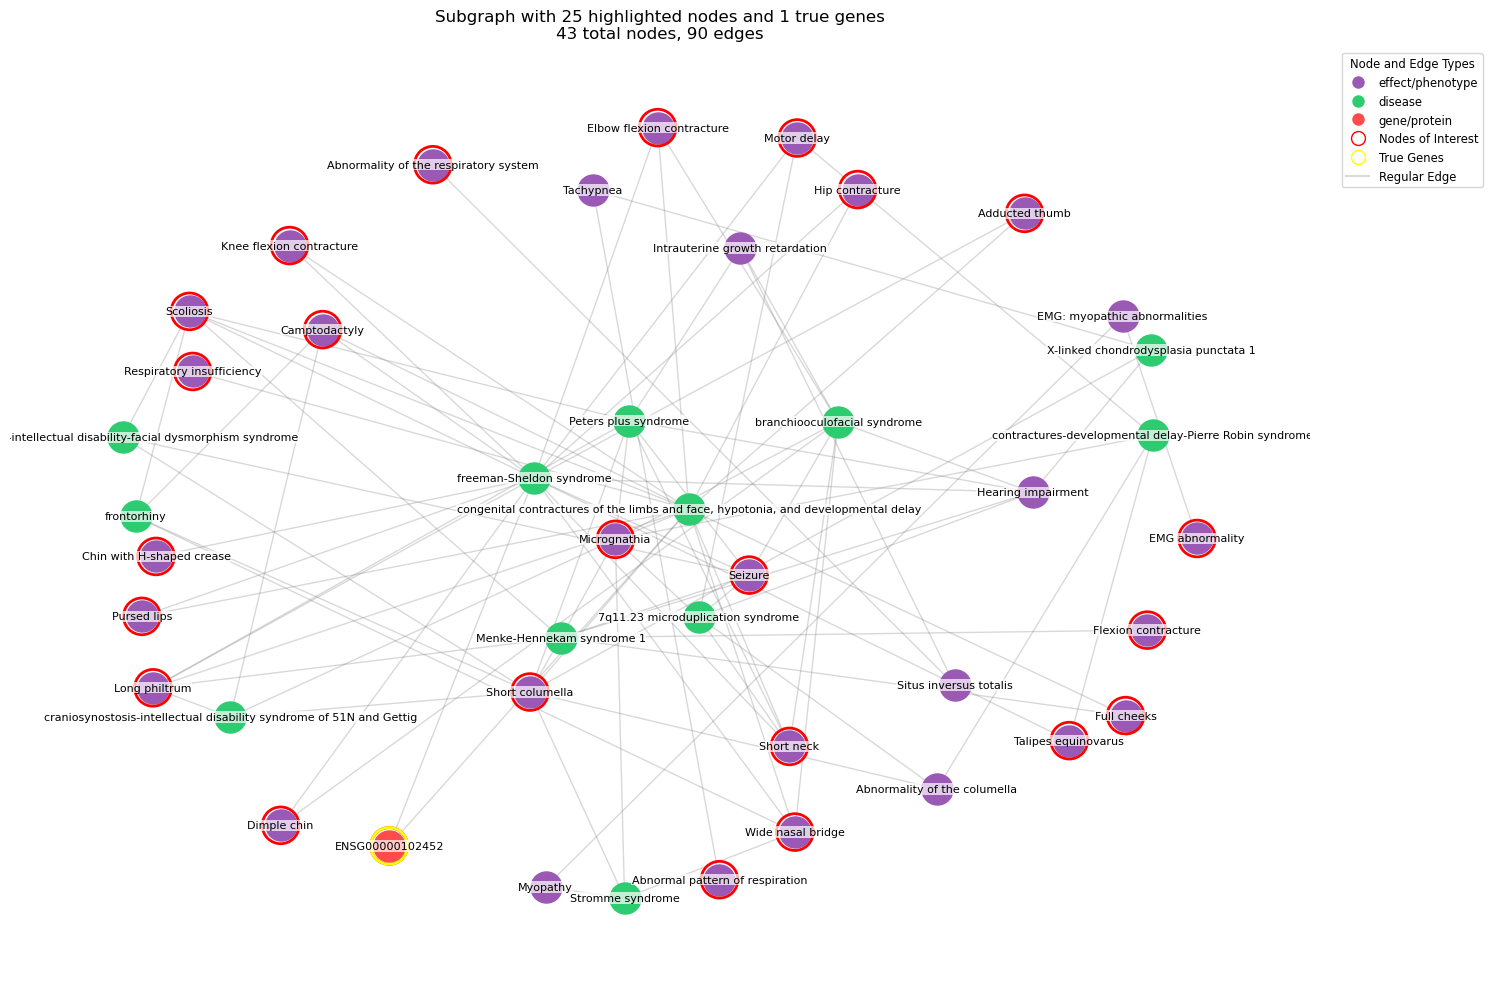

In [15]:
## Plot out the test data
## The grpah shows the connection between the patient's phenotypes, the candidate genes and the true genes of test data

i=1

kg.visualize_subgraph([str(n) for n in test_patients_phenotypes_list[i] + test_all_candidate_genes[i] + test_patients_genes[i]], 
                                true_gene_ids=[str(k) for k in test_patients_genes[i]])

In [16]:
## To map the local id to global id
train_nx_subgraph = []
train_pg_subgraph = []

for i in range(len(train_patients_phenotypes_list)):
    subgraph = kg.create_subgraph([str(n) for n in train_patients_phenotypes_list[i] + train_all_candidate_genes[i] + train_patients_genes[i]], 
                                true_gene_ids=[str(k) for k in train_patients_genes[i]])
    pg_graph = kg.create_pyg_data_from_subgraph(subgraph)
    train_nx_subgraph.append(subgraph)
    train_pg_subgraph.append(pg_graph)

In [17]:
print(train_pg_subgraph[0])
print(train_pg_subgraph[0].original_ids)
## x = 58 nodes, there are 7 types of nodes
## edge_index: 196 connections between nodes
## edge_attr: 15 types of the connections
## There are 36224 patients in the training data

Data(
  x=[58, 7],
  edge_index=[2, 196],
  edge_attr=[196, 15],
  node_mapping={
    14138=0,
    2491=1,
    9967=2,
    1591=3,
    24307=4,
    14341=5,
    14042=6,
    54520=7,
    51614=8,
    14744=9,
    51663=10,
    15274=11,
    20698=12,
    14015=13,
    10649=14,
    14016=15,
    54643=16,
    16340=17,
    27869=18,
    988=19,
    5784=20,
    26446=21,
    15350=22,
    3170=23,
    12554=24,
    14012=25,
    14430=26,
    19674=27,
    60332=28,
    12868=29,
    15726=30,
    27771=31,
    15279=32,
    28869=33,
    395=34,
    2448=35,
    14120=36,
    12980=37,
    26552=38,
    10335=39,
    729=40,
    4536=41,
    14434=42,
    69662=43,
    25375=44,
    1604=45,
    14231=46,
    23595=47,
    15322=48,
    14013=49,
    19829=50,
    20953=51,
    19172=52,
    15567=53,
    14594=54,
    5925=55,
    14923=56,
    20079=57,
  },
  node_names=[58],
  original_ids=[58],
  node_type_mapping={
    biological_process=0,
    cellular_component=1,
    disease=

In [18]:
val_nx_subgraph = []
val_pg_subgraph = []

for i in range(len(val_patients_phenotypes_list)):

    # Without patients
    subgraph = kg.create_subgraph([str(n) for n in val_patients_phenotypes_list[i]+ val_all_candidate_genes[i]+ val_patients_genes[i]], true_gene_ids = [str(k) for k in val_patients_genes[i]])
    pg_graph = kg.create_pyg_data_from_subgraph(subgraph)
    val_nx_subgraph.append(subgraph)
    val_pg_subgraph.append(pg_graph)

In [19]:
val_pg_subgraph[0]

Data(
  x=[84, 7],
  edge_index=[2, 282],
  edge_attr=[282, 15],
  node_mapping={
    3864=0,
    56545=1,
    15547=2,
    61011=3,
    14091=4,
    6002=5,
    2801=6,
    27779=7,
    17079=8,
    6885=9,
    11425=10,
    28154=11,
    14480=12,
    27984=13,
    1020=14,
    21302=15,
    26932=16,
    20353=17,
    5672=18,
    2693=19,
    14492=20,
    49099=21,
    8505=22,
    1495=23,
    22133=24,
    10760=25,
    14051=26,
    11675=27,
    61682=28,
    5074=29,
    18333=30,
    17089=31,
    15822=32,
    13916=33,
    20849=34,
    4447=35,
    24771=36,
    14100=37,
    15374=38,
    3430=39,
    25635=40,
    33=41,
    22312=42,
    50922=43,
    14179=44,
    26224=45,
    16587=46,
    14029=47,
    14079=48,
    3976=49,
    14427=50,
    21688=51,
    60134=52,
    14093=53,
    14421=54,
    935=55,
    7955=56,
    28716=57,
    70347=58,
    15652=59,
    4425=60,
    20351=61,
    454=62,
    14391=63,
    21390=64,
    15314=65,
    22041=66,
    10236=67

In [20]:
test_nx_subgraph = []
test_pg_subgraph = []

for i in range(len(test_patients_phenotypes_list)):
    subgraph = kg.create_subgraph([str(n) for n in test_patients_phenotypes_list[i] + test_all_candidate_genes[i] + test_patients_genes[i]], 
                                true_gene_ids=[str(k) for k in test_patients_genes[i]])
    pg_graph = kg.create_pyg_data_from_subgraph(subgraph)
    test_nx_subgraph.append(subgraph)
    test_pg_subgraph.append(pg_graph)

In [21]:
## To get the number of true gene
all_true_gene_ids = []

for patient in train_pg_subgraph:
    all_true_gene_ids.extend(patient.true_gene_ids)

for patient in val_pg_subgraph:
    all_true_gene_ids.extend(patient.true_gene_ids)
    
for patient in test_pg_subgraph:
    all_true_gene_ids.extend(patient.true_gene_ids)

## Get the unique true gene ids
unique_true_gene_ids = set(all_true_gene_ids)
print("the number of unique true gene ids is:",len(unique_true_gene_ids))

## Mapping all unique true gene ids to a index from 0 to the number of unique true gene ids
gene_id_mapping = {gene_id: idx for idx, gene_id in enumerate(unique_true_gene_ids)}
print(gene_id_mapping)

## Add the true gene ids back to the graph
for patient in train_pg_subgraph:
    patient.y = torch.tensor([gene_id_mapping[gene_id] for gene_id in patient.true_gene_ids], dtype=torch.long)

for patient in val_pg_subgraph:
    patient.y = torch.tensor([gene_id_mapping[gene_id] for gene_id in patient.true_gene_ids], dtype=torch.long)

for patient in test_pg_subgraph:
    patient.y = torch.tensor([gene_id_mapping[gene_id] for gene_id in patient.true_gene_ids], dtype=torch.long)

print(train_pg_subgraph[0].true_gene_ids)
print(train_pg_subgraph[0].y)

print(val_pg_subgraph[0].true_gene_ids)
print(val_pg_subgraph[0].y)

print(test_pg_subgraph[0].true_gene_ids)
print(test_pg_subgraph[0].y)

the number of unique true gene ids is: 2405
{4: 0, 10: 1, 8204: 2, 8208: 3, 18: 4, 8210: 5, 22: 6, 23: 7, 29: 8, 30: 9, 8224: 10, 33: 11, 37: 12, 8231: 13, 41: 14, 8234: 15, 43: 16, 42: 17, 8246: 18, 61: 19, 67: 20, 8266: 21, 74: 22, 8268: 23, 78: 24, 80: 25, 83: 26, 85: 27, 87: 28, 88: 29, 8281: 30, 8283: 31, 8284: 32, 92: 33, 95: 34, 97: 35, 98: 36, 100: 37, 111: 38, 8305: 39, 8318: 40, 130: 41, 133: 42, 143: 43, 144: 44, 146: 45, 150: 46, 8345: 47, 154: 48, 162: 49, 163: 50, 57507: 51, 57506: 52, 169: 53, 8362: 54, 173: 55, 177: 56, 178: 57, 8371: 58, 8372: 59, 57521: 60, 8376: 61, 8378: 62, 187: 63, 8379: 64, 8388: 65, 8395: 66, 207: 67, 209: 68, 212: 69, 8405: 70, 213: 71, 8411: 72, 8416: 73, 8422: 74, 232: 75, 8428: 76, 238: 77, 242: 78, 8434: 79, 8437: 80, 246: 81, 8439: 82, 245: 83, 249: 84, 57595: 85, 8446: 86, 256: 87, 8454: 88, 8456: 89, 8458: 90, 8462: 91, 8464: 92, 57618: 93, 8466: 94, 276: 95, 279: 96, 8473: 97, 8477: 98, 8480: 99, 288: 100, 57632: 101, 291: 102, 8483: 10

In [22]:
## Set nn.embedding layer for data.x
import torch.nn as nn

all_original_ids = set()

for patient_graph in train_pg_subgraph:
    all_original_ids.update(patient_graph.original_ids)

for patient_graph in val_pg_subgraph:
    all_original_ids.update(patient_graph.original_ids)

for patient_graph in test_pg_subgraph:
    all_original_ids.update(patient_graph.original_ids)

global_node_ids = sorted(all_original_ids)

## map the global node ids to index
node_id_mapping = {global_id: idx for idx, global_id in enumerate(global_node_ids)}

num_nodes = len(global_node_ids)  # Total number of unique nodes
embedding_dim = 32 # Define the embedding size

embedding_layer = nn.Embedding(num_nodes, embedding_dim)

## Apply the embedding layer to each patient's graph
def preparefordatax(pg_subgraph_list):
    """Applies the nn.Embedding layer to each patient's graph"""
    for pg_graph in pg_subgraph_list:
        # Ensure original_ids is a list
        node_indices = torch.tensor(
            [node_id_mapping[node_id] for node_id in pg_graph.original_ids],
            dtype=torch.long
        )

        # Get embeddings for this patient graph
        node_embeddings = embedding_layer(node_indices)  # Shape: (num_nodes_in_graph, embedding_dim)

        # Assign embeddings to the patient's graph
        pg_graph.x = node_embeddings

# Apply embeddings to all datasets
preparefordatax(train_pg_subgraph)
preparefordatax(val_pg_subgraph)
preparefordatax(test_pg_subgraph)

print(f"Total unique nodes: {num_nodes}")
print(f"Embedding dimension: {embedding_dim}")
print(f"Sample embedding for first patient in train: {train_pg_subgraph[0].x}")


Total unique nodes: 24010
Embedding dimension: 32
Sample embedding for first patient in train: tensor([[-0.8569, -0.7743, -0.5602,  ..., -0.5629, -0.1663,  0.4048],
        [-0.2661,  1.2361,  0.6018,  ..., -0.2119,  0.2581, -0.1260],
        [-0.0856,  0.1259, -1.7326,  ..., -2.1126,  0.6574, -0.5867],
        ...,
        [ 1.3804, -0.1909, -0.3660,  ...,  0.4804, -0.3066,  0.2071],
        [ 2.1026, -0.2858,  0.9360,  ..., -0.4764, -1.6974, -0.2031],
        [-0.9726, -0.4812, -1.3387,  ...,  1.6679,  0.9557, -1.1954]],
       grad_fn=<EmbeddingBackward0>)


In [23]:
## Preprocess the trainign data

from torch_geometric.data import Data

def preprocess_graph_data(dataset):
    processed_graphs = []
   
    for data in dataset:
        
        new_data = Data(
            edge_index=data.edge_index,
            y=data.y,
            x=data.x
        )
        processed_graphs.append(new_data)
    
    return processed_graphs

train_data = preprocess_graph_data(train_pg_subgraph)
val_data = preprocess_graph_data(val_pg_subgraph)
test_data = preprocess_graph_data(test_pg_subgraph)

In [24]:
print(train_data[0])
print(train_data[0].x)
print(train_data[0].edge_index)
print(train_data[0].y)

Data(x=[58, 32], edge_index=[2, 196], y=[1])
tensor([[-0.8569, -0.7743, -0.5602,  ..., -0.5629, -0.1663,  0.4048],
        [-0.2661,  1.2361,  0.6018,  ..., -0.2119,  0.2581, -0.1260],
        [-0.0856,  0.1259, -1.7326,  ..., -2.1126,  0.6574, -0.5867],
        ...,
        [ 1.3804, -0.1909, -0.3660,  ...,  0.4804, -0.3066,  0.2071],
        [ 2.1026, -0.2858,  0.9360,  ..., -0.4764, -1.6974, -0.2031],
        [-0.9726, -0.4812, -1.3387,  ...,  1.6679,  0.9557, -1.1954]],
       grad_fn=<EmbeddingBackward0>)
tensor([[ 0, 38,  1, 40,  1, 10,  2,  6,  2, 42,  3, 34,  3, 31,  4, 25,  4, 13,
          4, 15,  4, 26,  4,  9,  4, 11,  5, 57,  5, 38,  5, 50,  5, 33,  5, 47,
          6, 20,  6, 50,  7,  8,  8, 45,  8, 55,  9, 46,  9, 54,  9, 51,  9, 50,
          9, 57,  9, 21,  9, 31,  9, 33,  9, 44,  9, 47, 10, 40, 10, 19, 10, 45,
         10, 41, 10, 29, 11, 54, 11, 47, 11, 31, 11, 21, 11, 33, 12, 56, 12, 22,
         12, 30, 13, 54, 13, 51, 13, 47, 13, 57, 13, 18, 13, 33, 14, 42, 15, 39

In [25]:
from torch_geometric.data import DataLoader

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64)
test_loader = DataLoader(test_data, batch_size=64)

/home/kai/anaconda3/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import (
    GCNConv, GraphConv, SAGEConv, GIN, 
    global_mean_pool, global_add_pool
)
from torch_geometric.utils import dense_to_sparse

#Node-Level Module (F1)
class F1NodeLevelModule(nn.Module):
    def __init__(self, input_dim, hidden_dim, embedding_dim, conv_type='Graph',
                 dropout=0.2, pooling="mean", num_layers=2):
        super().__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.dropout = dropout

        # Choose GNN Layer Type
        if conv_type == "GCN":
            Conv = GCNConv
        elif conv_type == "Graph":
            Conv = GraphConv
        elif conv_type == "SAGE":
            Conv = SAGEConv
        elif conv_type == "GIN":
            Conv = lambda in_dim, out_dim: GIN(
                nn=nn.Sequential(
                    nn.Linear(in_dim, out_dim),
                    nn.ReLU(),
                    nn.Linear(out_dim, out_dim)
                )
            )
        else:
            raise ValueError(f"Unknown conv_type: {conv_type}")

        # Define GNN layers
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()

        # First Layer
        self.convs.append(Conv(input_dim, hidden_dim))
        self.bns.append(nn.BatchNorm1d(hidden_dim))

        # Hidden Layers
        for _ in range(num_layers - 2):
            self.convs.append(Conv(hidden_dim, hidden_dim))
            self.bns.append(nn.BatchNorm1d(hidden_dim))

        # Last Layer
        self.convs.append(Conv(hidden_dim, embedding_dim))
        self.bns.append(nn.BatchNorm1d(embedding_dim))

        self.dropout_layer = nn.Dropout(dropout)
        self.pooling = global_mean_pool if pooling == "mean" else global_add_pool

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        for conv, bn in zip(self.convs[:-1], self.bns[:-1]):
            x = conv(x, edge_index)
            x = bn(x)
            x = F.relu(x)
            x = self.dropout_layer(x)

        # Final Layer
        x = self.convs[-1](x, edge_index)
        x = self.bns[-1](x)
        node_embeddings = self.dropout_layer(x)

        # Graph-Level Embeddings
        graph_embeddings = self.pooling(node_embeddings, batch)
        return node_embeddings, graph_embeddings

#Population-Level Module (F2)
class F2PopulationLevelGraph(nn.Module):
    def __init__(self, embedding_dim, latent_dim, temperature=1.0, threshold=0.05):
        super().__init__()

        self.embedding_dim = embedding_dim
        self.latent_dim = latent_dim

        # Latent Space Transformation
        self.latent_transform = nn.Sequential(
            nn.Linear(embedding_dim, latent_dim * 2),
            nn.ReLU(),
            nn.BatchNorm1d(latent_dim * 2),
            nn.Dropout(0.2),
            nn.Linear(latent_dim * 2, latent_dim)
        )

        # Learnable Parameters
        self.temperature = nn.Parameter(torch.tensor(temperature, dtype=torch.float32))
        self.threshold = nn.Parameter(torch.tensor(threshold, dtype=torch.float32))
        self.mu = nn.Parameter(torch.tensor(1.0, dtype=torch.float32))  # Learnable KL params
        self.sigma = nn.Parameter(torch.tensor(1.0, dtype=torch.float32)) 

    def forward(self, graph_embeddings):
        latent_space = self.latent_transform(graph_embeddings)
        latent_space = F.normalize(latent_space, p=2, dim=-1)

        # Compute Pairwise Distances
        pairwise_distances = torch.cdist(latent_space, latent_space, p=2)

        # Compute Adjacency Matrix
        adjacency_matrix = torch.sigmoid(-self.temperature * pairwise_distances.pow(2) + self.threshold)

        # Ensure edge_index, edge_weight exist
        edge_index = (adjacency_matrix > 0.5).nonzero(as_tuple=True)
        edge_index = torch.stack((edge_index[0], edge_index[1]), dim=0).long()
        edge_weight = adjacency_matrix[edge_index[0], edge_index[1]]

        # Compute KL loss inside F2
        n_nodes = adjacency_matrix.shape[0]
        softhist = SoftHistogram(bins=n_nodes, min=0.5, max=n_nodes + 0.5, sigma=0.6)
        kl_loss = self._compute_kl_loss(adjacency_matrix, n_nodes, softhist)

        return adjacency_matrix, edge_index, edge_weight, kl_loss


# Classifier Module (F3)
class F3Classifier(nn.Module):
    def __init__(self, input_dim_h, gnn_hidden_dim, num_classes, conv_type="GCN",
                 gnn_layers=2, dropout=0.2, gene_embedding_dim=64):
        super().__init__()

        self.gene_embedding = nn.Embedding(num_classes, gene_embedding_dim)

        if conv_type == "GCN":
            Conv = GCNConv
        elif conv_type == "Graph":
            Conv = GraphConv
        else:
            raise ValueError(f"Unknown conv_type: {conv_type}")

        # GNN Layers
        self.gnn_layers = nn.ModuleList()
        self.gnn_layers.append(Conv(input_dim_h + gene_embedding_dim, gnn_hidden_dim))

        for _ in range(gnn_layers - 1):
            self.gnn_layers.append(Conv(gnn_hidden_dim, gnn_hidden_dim))

        self.batch_norms = nn.ModuleList([nn.BatchNorm1d(gnn_hidden_dim) for _ in range(gnn_layers)])
        self.dropout = nn.Dropout(dropout)
        self.ap_transform = nn.Linear(num_classes, num_classes, bias=False)
        self.classifier = nn.Linear(gnn_hidden_dim, num_classes)

    def forward(self, h, edge_index, batch, Ap, edge_weight, gene_ids):
        gene_embeddings = self.gene_embedding(gene_ids)
        gene_embeddings = gene_embeddings[batch]
        h = torch.cat([h, gene_embeddings], dim=-1)

        for gnn, bn in zip(self.gnn_layers, self.batch_norms):
            if edge_weight is not None and isinstance(gnn, (GCNConv, GraphConv)):
                h_new = gnn(h, edge_index, edge_weight)
            else:
                h_new = gnn(h, edge_index)

            h_new = bn(h_new)
            h_new = F.relu(h_new)
            h_new = self.dropout(h_new)

            if h.shape[-1] == h_new.shape[-1]:
                h = h + h_new
            else:
                h = h_new  

        # Global Pooling
        graph_embeddings = global_mean_pool(h, batch)
        batch_size = batch.unique().size(0)
        graph_embeddings = graph_embeddings.view(batch_size, -1)

        if Ap is not None:
            Ap = Ap / (Ap.sum(dim=1, keepdim=True) + 1e-6)  # Normalize adjacency matrix
            graph_embeddings = torch.matmul(Ap, graph_embeddings)

        logits = self.classifier(graph_embeddings)

        return logits



In [59]:
import pytorch_lightning as pl
from pytorch_lightning import LightningModule

class GiG(pl.LightningModule):
    def __init__(self, config):
        super().__init__()
        self.automatic_optimization = False
        self.node_level_module = F1NodeLevelModule(
            input_dim=config["input_dim"],
            hidden_dim=config["hidden_dim"],
            embedding_dim=config["embedding_dim"],
            conv_type=config["conv_type"],
            dropout=config["dropout"]
        )

        self.population_level_module = F2PopulationLevelGraph(
            embedding_dim=config["embedding_dim"],
            latent_dim=config["latent_dim"]
        )

        self.classifier = F3Classifier(
            input_dim_h=config["embedding_dim"],
            gnn_hidden_dim=config["gnn_hidden_dim"],
            num_classes=config["num_classes"],
            conv_type=config["conv_type"],
            gnn_layers=config["gnn_layers"],
            dropout=config["dropout"]
        )

    def forward(self, data):
        feature_matrix, graph_embeddings = self.node_level_module(data)
        adjacency_matrix, edge_index, edge_weight, kl_loss = self.population_level_module(graph_embeddings)
        logits = self.classifier(feature_matrix, edge_index, data.batch, adjacency_matrix, edge_weight, data.y)

        return logits, adjacency_matrix, kl_loss


In [62]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torchmetrics
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR
import shutil
import os

# 🔹 Define Loss Dictionary
losses = nn.ModuleDict({
    'BCEWithLogitsLoss': nn.BCEWithLogitsLoss(),
    'CrossEntropyLoss': nn.CrossEntropyLoss(),
    'MultiTaskBCE': nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([10]))
})

class GiGTrainer(pl.LightningModule):
    def __init__(self, config):
        super().__init__()
        # Add this line at the beginning of __init__
        self.automatic_optimization = False  # Add this line here
        
        self.config = config
        self.save_hyperparameters(config)
        
        #Initialize the GiG Model
        self.model = GiG(config)
        
        #Set loss function based on config
        self.initial_loss = losses[config["loss"]]
        
        #Set up directory for saving results
        self.saving_path = os.path.join(config["saving_path"], 'plots/')
        if os.path.exists(self.saving_path):
            shutil.rmtree(self.saving_path)
        os.makedirs(self.saving_path, mode=0o777, exist_ok=True)
        
        self.alpha = config["alpha"]

    def forward(self, data):
        return self.model(data)

    def training_step(self, batch, batch_idx):
        optimizers = self.optimizers()
        for opt in optimizers:
            opt.zero_grad()

        metrics, _ = self._shared_step(batch, "train")
        
        self.manual_backward(metrics["loss"])
        
        # You might want to add these lines to step the optimizers
        for opt in optimizers:
            opt.step()

        self.log_dict(metrics, prog_bar=True, batch_size=len(batch.y))
        return metrics
        
    def _shared_step(self, data, addition):
        """ Compute model output, loss, and metrics. """

        logits, adj_matrix, kl_loss = self.model(data)

        labels = data.y.view(-1).long()

        # Compute classification loss
        classification_loss = self.initial_loss(logits, labels)

        # Ensure KL loss is included in backprop
        total_loss = classification_loss + self.alpha * kl_loss  

        acc = torchmetrics.functional.accuracy(
            logits.argmax(dim=-1), labels, task='multiclass', num_classes=logits.shape[1]
        )
        f1 = torchmetrics.functional.f1_score(
            logits.argmax(dim=-1), labels, task='multiclass', num_classes=logits.shape[1]
        )

        try:
            avg_coeff, eigenDecomposition_coeff = compute_clustering_coeff(adj_matrix.cpu().numpy())
        except:
            avg_coeff = 0.0
            eigenDecomposition_coeff = 0.0

        metrics = {
            addition + "_acc": acc, 
            addition + "_f1": f1,
            addition + "_avg_coeff": avg_coeff,
            addition + "_eigenDecomposition_coeff": eigenDecomposition_coeff,
            "loss": total_loss,
            addition + "_loss": total_loss,
            addition + "_classification_loss": classification_loss,
            addition + "_kl_loss": kl_loss
        }

        return metrics, adj_matrix

    def validation_step(self, batch, batch_idx):
        metrics, _ = self._shared_step(batch, "val")
        self.log_dict(metrics, prog_bar=True, batch_size=len(batch.y))
        return metrics
    
    def test_step(self, batch, batch_idx):
        metrics, _ = self._shared_step(batch, "test")
        self.log_dict(metrics, batch_size=len(batch.y))
        return metrics

    def configure_optimizers(self):
        """ Set up optimizers and learning rate schedulers. """

        # 🔍 Debugging: Print requires_grad status of all model parameters
        for name, param in self.model.named_parameters():
            print(f"🔍 {name} requires grad: {param.requires_grad}")

        # 🔥 Force requires_grad=True in case any parameter is frozen
        for param in self.model.parameters():
            param.requires_grad_(True)

        population_level_module_par = [
            param for name_, param in self.model.population_level_module.named_parameters()
            if name_ not in ['temp', 'theta', 'mu', 'sigma']
        ]
        population_level_module_par.extend(self.model.node_level_module.parameters())
        population_level_module_par.extend(self.model.classifier.parameters())

        # Main optimizer
        optimizer = torch.optim.Adam(
            population_level_module_par, 
            lr=self.config["lr"]
        )

        # Special parameters optimizers
        lgl_optimizer = torch.optim.Adam(
            [
                self.model.population_level_module.temperature,
                self.model.population_level_module.threshold,
            ], 
            lr=self.config["lr_theta_temp"]
        )

        # Scheduler
        scheduler = {
            "scheduler": ReduceLROnPlateau(
                optimizer,
                mode='min',
                patience=10,
                threshold=0.0001,
                verbose=True
            ),
            "interval": "epoch",
            "monitor": "val_loss"
        } if self.config["scheduler"] == "ReduceLROnPlateau" else {
            "scheduler": CosineAnnealingLR(optimizer, T_max=10),
            "interval": "epoch",
            "monitor": "val_loss"
        }

        return [optimizer, lgl_optimizer], [scheduler]


In [63]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import (
    ModelCheckpoint,
    EarlyStopping,
    LearningRateMonitor
)
from pytorch_lightning.loggers import TensorBoardLogger

# Setup callbacks
callbacks = [
    ModelCheckpoint(
        monitor='val_loss',
        dirpath='checkpoints',
        filename='gig-{epoch:02d}-{val_loss:.2f}',
        save_top_k=3,
        mode='min',
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        mode='min',
        verbose=True
    ),
    LearningRateMonitor(logging_interval='epoch')
]

# Setup logger
logger = TensorBoardLogger("lightning_logs", name="gig_model")

config = {
    "input_dim": 32,
    "hidden_dim": 64,
    "embedding_dim": 128,
    "latent_dim": 16,
    "gnn_hidden_dim": 64,
    "num_classes": 2405,
    "conv_type": "Graph",
    "gnn_layers": 2,
    "dropout": 0.2,
    "lr": 0.001,  # Main learning rate
    "optimizer_lr": 0.001,  # ✅ Add this line
    "lr_theta_temp": 0.0005,  # ✅ Also ensure this exists
    "alpha": 0.1,
    "target_distribution": "power_law",
    "loss": "CrossEntropyLoss",
    "saving_path": "./Output",
    "scheduler": "ReduceLROnPlateau"
    
}


model = GiGTrainer(config)

trainer = Trainer(
    max_epochs=5,
    accelerator='gpu',
    devices='auto',
    precision='16-mixed',
    callbacks=callbacks,
    logger=logger,
    deterministic=False,
    benchmark=True
)

trainer.fit(model, train_loader, val_loader)
trainer.fit(model, test_loader)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kai/anaconda3/lib/python3.11/site-packages/pytorch_lightning/core/optimizer.py:317: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | model        | GiG              | 6.2 M  | train
1 | initial_loss | CrossEntropyLoss | 0      | train
----------------------------------------------------------
6.2 M     Trainable params
0         Non-trainable params
6.2 M     Total params
24.613    Total estimated model params size (MB)
40        Modules in train mode
0         Modules in eval mode


🔍 node_level_module.convs.0.lin_rel.weight requires grad: True
🔍 node_level_module.convs.0.lin_rel.bias requires grad: True
🔍 node_level_module.convs.0.lin_root.weight requires grad: True
🔍 node_level_module.convs.1.lin_rel.weight requires grad: True
🔍 node_level_module.convs.1.lin_rel.bias requires grad: True
🔍 node_level_module.convs.1.lin_root.weight requires grad: True
🔍 node_level_module.bns.0.weight requires grad: True
🔍 node_level_module.bns.0.bias requires grad: True
🔍 node_level_module.bns.1.weight requires grad: True
🔍 node_level_module.bns.1.bias requires grad: True
🔍 population_level_module.temperature requires grad: True
🔍 population_level_module.threshold requires grad: True
🔍 population_level_module.mu requires grad: True
🔍 population_level_module.sigma requires grad: True
🔍 population_level_module.latent_transform.0.weight requires grad: True
🔍 population_level_module.latent_transform.0.bias requires grad: True
🔍 population_level_module.latent_transform.2.weight require

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/kai/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


AttributeError: 'F2PopulationLevelGraph' object has no attribute '_compute_kl_loss'

In [ ]:
# import networkx as nx

# # Assuming test_nx_subgraph is a list of graphs
# subgraph = train_nx_subgraph[3]  # First subgraph

# # Check if the graph is directed
# is_directed = subgraph.is_directed()

# # Check if the graph is connected
# # For directed graphs, check strongly connected or weakly connected
# if is_directed:
#     is_connected = nx.is_strongly_connected(subgraph)  # Strongly connected
#     is_weakly_connected = nx.is_weakly_connected(subgraph)  # Weakly connected
#     print(f"Graph is directed: {is_directed}")
#     print(f"Graph is strongly connected: {is_connected}")
#     print(f"Graph is weakly connected: {is_weakly_connected}")
# else:
#     is_connected = nx.is_connected(subgraph)  # Connected (undirected case)
#     print(f"Graph is directed: {is_directed}")
#     print(f"Graph is connected: {is_connected}")

In [ ]:
# # Create the output directory if it doesn't exist
# output_folder = './Graph Outputs'
# os.makedirs(output_folder, exist_ok=True)

# # Combined lists to save
# lists_to_save = {
#     'val_nx_subgraph': val_nx_subgraph,
#     'val_pg_subgraph': val_pg_subgraph,

#     'train_nx_subgraph': train_nx_subgraph,
#     'train_pg_subgraph': train_pg_subgraph,

#     'test_nx_subgraph': test_nx_subgraph,
#     'test_pg_subgraph': test_pg_subgraph,
# }

# # Save each list using pickle
# for list_name, list_data in lists_to_save.items():
#     file_path = os.path.join(output_folder, f'{list_name}.pkl')
#     with open(file_path, 'wb') as file:
#         pickle.dump(list_data, file)
#     print(f'Saved {list_name} to {file_path}')